# Sentiment analysis on Covid-19 tweets 

Objective:
-------------------------------------------------------------------------------------
Classify 45k tweets on Covid-19 as positive or negative based on the following machine learning and deeplearning models: 

* Multinomial Naive Bayes Model
* Random Forests 
* ADABoost
* XGBoost
* Simple RNN
* LSTM 
* GRU
* Bidirectional LSTM
* BERT 

For machine learning models, the tweets are preprocessed using the following NLP methods: 

* Bag-of-words model
* Bag-of-POS model
* Pre-trained Spacy word embeddings

For neural networks, we use the following preprocessing methods: 

* Pre-trained Spacy word embeddings
* Keras embedding layers

Results:
----------------------------------------------------------------------------------------
* Among machine learning models, XGBoost trained on a pre-trained word embedding has the best performance in terms of accuracy (84%) and AUC ROC (91%)
* Among deeplearning models, BERT has the best performance (accuracy = 95%)

References: 
-------------------------------------------------------------------------------------------

* https://www.kaggle.com/andreshg/nlp-glove-bert-tf-idf-lstm-explained
* https://www.kaggle.com/tanulsingh077/deep-learning-for-nlp-zero-to-transformers-bert#Bi-Directional-RNN's
* Azunre, P. (2021). Transfer learning for natural language processing. Simon and Schuster.
* Ferrario, A., & Nägelin, M. (2020). The art of natural language processing: classical, modern and contemporary approaches to text document classification. Modern and Contemporary Approaches to Text Document Classification (March 1, 2020).


In [169]:
from __future__ import absolute_import, division, print_function, unicode_literals

#pip install xgboost==1.4.2

import pandas as pd
import numpy as np
import re
from matplotlib import pyplot as plt
import string
import joblib

from warnings import filterwarnings
filterwarnings("ignore")

import nltk
from nltk import pos_tag, word_tokenize
from nltk.stem import WordNetLemmatizer 
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer

import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import collections
from collections import Counter
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve
from sklearn.metrics import auc 
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB

from xgboost import XGBClassifier

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam

from numpy import asarray
from numpy import savetxt
from numpy import loadtxt

import transformers
from transformers import BertTokenizer, TFBertModel

In [2]:
def preprocessor(text):
    # convert to lowercase, susbstitute non alphanumerical characters with whitespaces
    text = re.sub('<[^>]*>', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text)
    text = (re.sub('[\W]+', ' ', text.lower()) +
            ' '.join(emoticons).replace('-', ''))
    return text

In [3]:
def test_performance(model, X_test): 
    ''' Given a fitted model and a test set, returns optimal hyperparameters, AUC and accuracy '''
    clf_b = model.best_estimator_
    y_pred_proba = clf_b.predict_proba(X_test)
    y_pred = clf_b.predict(X_test)

    # performance metrics
    auc_res=roc_auc_score(y_test, y_pred_proba[:, 1])
    acc = accuracy_score(y_test, y_pred)
    
    return (model.best_params_, auc_res, acc)


In [4]:
stopwords = list(set(stopwords.words("english")))

# Data analytics

* There are no duplicated values in the dataset
* Missing values only in the location feature
* Most tweets have positive sentiment
* On average, each tweet has about 30 words

In [5]:
train_data=pd.read_csv("../input/covid-19-nlp-text-classification/Corona_NLP_test.csv",encoding="latin1")
test_data=pd.read_csv("../input/covid-19-nlp-text-classification/Corona_NLP_test.csv",encoding="latin1")

In [6]:
# merge train and test datasets
df = pd.concat([train_data, test_data], axis = 0)
df.shape

(7596, 6)

In [7]:
# duplicated tweets
duplicates = df[df.duplicated()]
len(duplicates)

3798

In [8]:
df.isnull().sum()

UserName            0
ScreenName          0
Location         1668
TweetAt             0
OriginalTweet       0
Sentiment           0
dtype: int64

In [9]:
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


<AxesSubplot:xlabel='Sentiment'>

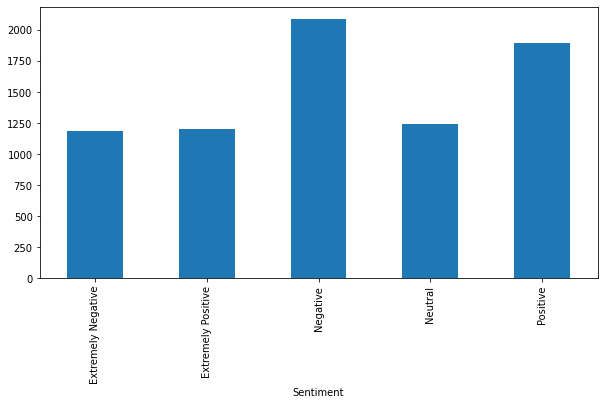

In [10]:
counts = df.groupby("Sentiment")["Sentiment"].agg("count")

fig, ax = plt.subplots(figsize=(10,5))
counts.plot.bar()

In [11]:
# remove neutral tweets
df.drop(df[df.Sentiment == "Neutral"].index, inplace = True)

df.Sentiment.unique()

array(['Extremely Negative', 'Positive', 'Extremely Positive', 'Negative'],
      dtype=object)

In [12]:
# Aggregate extremely positive/negative values
df = df.replace("Extremely Positive", "Positive")
df = df.replace("Extremely Negative", "Negative")

df.Sentiment.unique()

array(['Negative', 'Positive'], dtype=object)

<AxesSubplot:xlabel='Sentiment'>

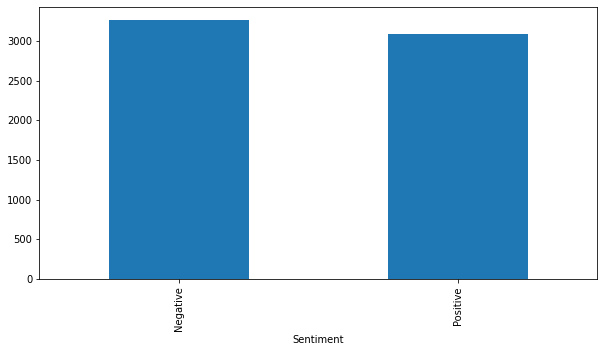

In [13]:
counts = df.groupby("Sentiment")["Sentiment"].agg("count")
fig, ax = plt.subplots(figsize=(10,5))

counts.plot.bar()

In [14]:
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
6,7,44959,NaN,03-03-2020,Voting in the age of #coronavirus = hand sanit...,Positive


In [15]:
# count number of words per headline. strip whitespaces at the beginning/end of the sentence 
# and tokenize by whitespace
df_select = df[["OriginalTweet", "Sentiment"]]
df_select["word_count"] = df_select["OriginalTweet"].apply(lambda x: len(x.strip().split(" ")))
df_select.head()

,OriginalTweet,Sentiment,word_count
0,TRENDING: New Yorkers encounter empty supermar...,Negative,23
1,When I couldn't find hand sanitizer at Fred Me...,Positive,31
2,Find out how you can protect yourself and love...,Positive,13
3,#Panic buying hits #NewYork City as anxious sh...,Negative,35
6,Voting in the age of #coronavirus = hand sanit...,Positive,12


In [16]:
# summary statistics of word counts
df_select["word_count"].describe()

count    6358.000000
mean       34.329663
std        10.979474
min         2.000000
25%        26.000000
50%        36.000000
75%        43.000000
max        71.000000
Name: word_count, dtype: float64

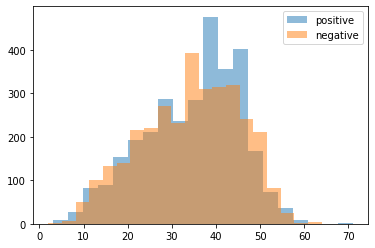

In [17]:
# distributions of word counts by sentiment
pos = df_select[df_select.Sentiment == "Positive"].word_count
neg =  df_select[df_select.Sentiment == "Negative"].word_count

plt.hist(pos, bins = 20, alpha = 0.5, label='positive')
plt.hist(neg, bins = 20, alpha = 0.5, label='negative')
plt.legend(loc='upper right')
plt.show()

In [19]:
df_select

,OriginalTweet,Sentiment,word_count
0,TRENDING: New Yorkers encounter empty supermar...,Negative,23
1,When I couldn't find hand sanitizer at Fred Me...,Positive,31
2,Find out how you can protect yourself and love...,Positive,13
3,#Panic buying hits #NewYork City as anxious sh...,Negative,35
6,Voting in the age of #coronavirus = hand sanit...,Positive,12
...,...,...,...
3792,"@RicePolitics @MDCounties Craig, will you call...",Negative,29
3793,Meanwhile In A Supermarket in Israel -- People...,Positive,18
3794,Did you panic buy a lot of non-perishable item...,Negative,34
3796,Gov need to do somethings instead of biar je r...,Negative,29


In [20]:
# save dataset
df_select.to_csv("./binary_data.csv",index = False, encoding = "utf-8")

# NLP Preprocessing

## Basic preprocessing: 

* Convert tweets to lowercase
* Remove punctuation and non alphanumerical characters

In [21]:
df = pd.read_csv("./binary_data.csv")

In [22]:
# select random tweet
text = df.OriginalTweet.iloc[400]
text

"Have been talking to lots of Trump supporters across the country these last couple of days, and the disdain for and distrust of the media right now is worse than I've seen at any point throughout this presidency."

In [23]:
# preprocess entire corpus
df['tweet_clean'] = df['OriginalTweet'].apply(preprocessor)
df.head()

,OriginalTweet,Sentiment,word_count,tweet_clean
0,TRENDING: New Yorkers encounter empty supermar...,Negative,23,trending new yorkers encounter empty supermark...
1,When I couldn't find hand sanitizer at Fred Me...,Positive,31,when i couldn t find hand sanitizer at fred me...
2,Find out how you can protect yourself and love...,Positive,13,find out how you can protect yourself and love...
3,#Panic buying hits #NewYork City as anxious sh...,Negative,35,panic buying hits newyork city as anxious sho...
4,Voting in the age of #coronavirus = hand sanit...,Positive,12,voting in the age of coronavirus hand sanitize...


## Bag-of- models

Bag-of- models are used to produce a real-valued representation of a text document that can used to train a ML model.

* Bag-of-words: count (with normalization) the occurences of each token in a text
* Bag-of-POS: count the occurence of each POS tag in a text. A POS is a set of words with similar sytactic behaviour (nouns, adjective, verbs, pronouns etc). POS tags are assigned to every word in a document and used in bag-of machine learning models. 

Bag-of-word models suffer from high dimensionality and sparseness of the real-valued representation. Bag-of-POS is usually more parsimonious than bag-of-words, since there usually are less POS-tags than words in a document, and can therefore be used to reduce dimensionality.

In [24]:
# tokenize the dataset with nltk tokenizer
text_processed = df.tweet_clean.apply( word_tokenize )
text_processed

0       [trending, new, yorkers, encounter, empty, sup...
1       [when, i, couldn, t, find, hand, sanitizer, at...
2       [find, out, how, you, can, protect, yourself, ...
3       [panic, buying, hits, newyork, city, as, anxio...
4       [voting, in, the, age, of, coronavirus, hand, ...
                              ...                        
6353    [ricepolitics, mdcounties, craig, will, you, c...
6354    [meanwhile, in, a, supermarket, in, israel, pe...
6355    [did, you, panic, buy, a, lot, of, non, perish...
6356    [gov, need, to, do, somethings, instead, of, b...
6357    [i, and, forestandpaper, members, are, committ...
Name: tweet_clean, Length: 6358, dtype: object

In [25]:
# POS-tags for the whole dataset
text_tagged = text_processed.apply(pos_tag)
text_tagged

0       [(trending, VBG), (new, JJ), (yorkers, NNS), (...
1       [(when, WRB), (i, NN), (couldn, VBP), (t, NN),...
2       [(find, VB), (out, RP), (how, WRB), (you, PRP)...
3       [(panic, JJ), (buying, NN), (hits, NNS), (newy...
4       [(voting, NN), (in, IN), (the, DT), (age, NN),...
                              ...                        
6353    [(ricepolitics, NNS), (mdcounties, NNS), (crai...
6354    [(meanwhile, RB), (in, IN), (a, DT), (supermar...
6355    [(did, VBD), (you, PRP), (panic, VB), (buy, VB...
6356    [(gov, NNS), (need, VBP), (to, TO), (do, VB), ...
6357    [(i, NN), (and, CC), (forestandpaper, JJ), (me...
Name: tweet_clean, Length: 6358, dtype: object

In [26]:
def retrieve_tags(text):
    # form a string of tags from POS-tag text
    return "-".join(tag for (word, tag) in text)

df["text_pos"] = text_tagged.apply(retrieve_tags)
df.text_pos

0       VBG-JJ-NNS-VBP-JJ-NN-NNS-VBD-NNS-IN-NN-VBN-RP-...
1       WRB-NN-VBP-NN-VBP-NN-NN-IN-JJ-NN-NN-VBD-TO-VB-...
2                VB-RP-WRB-PRP-MD-VB-PRP-CC-VBD-NNS-IN-NN
3       JJ-NN-NNS-VBP-NN-IN-JJ-NNS-NN-RB-IN-NN-NN-JJ-N...
4                 NN-IN-DT-NN-IN-NN-NN-NN-NN-VBD-JJ-NN-NN
                              ...                        
6353    NNS-NNS-VBP-MD-PRP-VB-IN-DT-JJ-NN-TO-VB-DT-JJ-...
6354    RB-IN-DT-NN-IN-JJ-NNS-NN-CC-VBG-RB-TO-VB-JJ-NN...
6355    VBD-PRP-VB-VB-DT-NN-IN-NN-JJ-NNS-VBP-NNS-NN-NN...
6356    NNS-VBP-TO-VB-NNS-RB-IN-JJ-NN-NN-VBP-JJ-NN-CC-...
6357    NN-CC-JJ-NNS-VBP-VBN-TO-DT-NN-IN-PRP$-NNS-CC-P...
Name: text_pos, Length: 6358, dtype: object

## Word embeddings
Associate a real-valued vector to each word in a document, so that words that occur in similar context (i.e. are semantically close) have a similar vector representation.

* word2vec: compute word embeddings using the concept of context, i.e. the words around a certain word in the text. The embeddings are calculated based on the probability of each word to appear in the context of every other word (word-word co-occurrences).

* Glove: unsupervised learning model trained on word-word co-occurence counts, computed with respect to the entire document as opposed to one context window at a time. Embeddings are computed based on the probability of a word to appear in the context of another word, given the entire vocabulary.

Spacy offers pre-trained word embedding models (such as "en_core_web_md")

In [27]:
# load pre-trained word embedding model from spacy
!python -m spacy download en_core_web_md

nlp = spacy.load('en_core_web_md') 

     |████████████████████████████████| 45.4 MB 74 kB/s             
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


In [28]:
# example on random tweet
print( nlp(text) )
print( )
print( nlp(text).vector[:20])

Have been talking to lots of Trump supporters across the country these last couple of days, and the disdain for and distrust of the media right now is worse than I've seen at any point throughout this presidency.

[-5.82235307e-02  1.30381927e-01 -7.90577978e-02 -1.20958954e-01
  6.67716190e-02  6.90214662e-03 -3.74554470e-02 -1.25759770e-03
  3.04305702e-02  2.46167827e+00 -1.11433275e-01  1.68819400e-03
  7.96426013e-02 -1.77416474e-01 -1.16737857e-01 -5.02916612e-02
 -1.06850974e-01  8.79178464e-01 -1.92295477e-01  3.82590177e-03]


In [ ]:
# stack embeddings of tweets
# each tweet has a 1x300 embedding
emb = np.vstack(df.tweet_clean.apply(lambda x: nlp(x).vector))
len(emb[0])

In [ ]:
# convert embeddings to dataframe
emb_df = pd.DataFrame(emb, columns = np.array([str(x) for x in range(0, len(emb[0]))]) )
print(emb_df.shape)
emb_df.head()

In [ ]:
# add embeddings to dataset
df_embed = pd.concat([df, emb_df], axis = 1)
df = df_embed.drop(columns=["OriginalTweet",'word_count'])

### Convert target label to real-valued

In [ ]:
# convert sentiment label to real-valued target
le = LabelEncoder()
le.fit(df.Sentiment)

df['target_encoded'] = le.transform(df.Sentiment)
df.target_encoded

In [ ]:
# save dataset
df.to_csv("./preprocessed_data.csv",index = False, encoding = "utf-8")

# Sentiment analysis with machine learning models

We consider the following classifiers:

* Multinomial Naive Bayes Model (benchmark)
* Random forests
* Adaptive boosting (ADABoost)
* Extreme Gradient Boosting (XGBoost)

The machine learning models are trained on a real-valued representation of the training data, produced with the following nlp preprocesssing methods: 

* Bag-of-words model
* Bag-of-POS model
* Pre-trained word embeddings

To reduce computational time, we train the machine learning models on a random sample with dimensions equal to 30% of the original data

In [29]:
df_imp = pd.read_csv("./preprocessed_data.csv")
df_imp.shape

(6358, 304)

In [30]:
# train the models on about 30% of the original data
df = df_imp.sample(frac = 0.3 ) 
df.shape

(1907, 304)

In [31]:
# reshuffle data
np.random.seed(0)
df = df.reindex(np.random.permutation(df.index))
df = df.reset_index(drop=True) # reset the index after the permutation

In [32]:
# define train and test size
train_size = int( len(df)*0.8 )
test_size = int( len(df) - train_size )
print(train_size, test_size)

1525 382


In [33]:
# split dataset
df_train = df.head(train_size)
y_train = df.head(train_size).target_encoded

df_test = df.tail(test_size)
y_test = df.tail(test_size).target_encoded

In [34]:
# set tfidf and cross validation parameters for all models
tfidf = TfidfVectorizer(strip_accents=None,
                        lowercase=False,
                        preprocessor=None)

cv = StratifiedKFold(n_splits=5, 
                     shuffle=False)

## Multinomial naive bayes model 
Probabilistic classifier with independence assumption between fetures

The model is trained on the real-valued representation of the tweets produces by nltk CountVectorizer(), which transforms text into a vector of token counts.
In the resulting sparse matrix, each column represents a unique word in the vocabulary, and each row represents a tweet in the dataset. The values of the matrix are the word counts. Words that do not appear in a certain tweet are given the value zero. 

In [41]:
X_train = df_train.tweet_clean
X_test = df_test.tweet_clean

In [42]:
# convert tweets into a real-valued matrix of token counts (sparse matrix with dim nr tweets, nr words)
vect = CountVectorizer(stop_words='english')
vect.fit(X_train)

x_train_dtm = vect.transform(X_train)
x_test_dtm = vect.transform(X_test)

In [43]:
# nrows = nr tweets, ncols = nr words
print("Shape training data: {}".format(x_train_dtm.shape) + "\nShape test data:{}".format(x_test_dtm.shape))

Shape training data: (1525, 6962)
Shape test data:(382, 6962)


In [44]:
# Multinomial Naive Bayes model
model = MultinomialNB()
model.fit(x_train_dtm, y_train)
# save fitted model
joblib.dump(model, "./NaiveBayes.joblib")

['./NaiveBayes.joblib']

In [45]:
# predict target label (0 or 1) 
y_pred = model.predict(x_test_dtm)

# predict probability of class == 1
y_pred_prob = model.predict_proba(x_test_dtm)

# performance metrics
auc_res = list()
acc = list()

auc_res.append( roc_auc_score(y_test, y_pred_prob[:, 1]) )
acc.append( accuracy_score(y_test, y_pred) )

## Random Forests


-----------------------------------------------------------------------------------------------------
Random forests are an ensemble learning method for classification and regression that operates by constructing a multitude of decision trees at training time. Random decision forests correct for decision trees' habit of overfitting to their training set.

The training algorithm for random forests applies the general technique of bootstrap aggregating, or bagging, to tree learners. Given a training set $X = x_1, ..., x_n$ with responses $Y = y_1, ..., y_n$, bagging repeatedly ($B$ times) selects a random sample with replacement of the training set and fits trees to these samples:

For $b = 1, ..., B$:
* Sample, with replacement, $n$ training examples from $X, Y$; call these $X_b, Y_b$.
* Train a classification or regression tree $f_b$ on $X_b, Y_b$.

After training, predictions for unseen samples can be made by averaging the predictions from all the individual regression trees on or by taking the majority vote in the case of classification trees.

This bootstrapping procedure leads to better model performance because it decreases the variance of the model, without increasing the bias. This means that while the predictions of a single tree are highly sensitive to noise in its training set, the average of many trees is not, as long as the trees are not correlated. Simply training many trees on a single training set would give strongly correlated trees; bootstrap sampling is a way of de-correlating the trees by showing them different training sets.

Random forests also include another type of bagging scheme: they use a modified tree learning algorithm that selects, at each candidate split in the learning process, a random subset of the features. This process is sometimes called "feature bagging". The reason for doing this is the correlation of the trees in an ordinary bootstrap sample: if one or a few features are very strong predictors for the response variable, these features will be selected in many of the $B trees, causing them to become correlated.

----------------------------------------------------------------------------------------------------

**For bag-of models**, NLP preprocessing is performed by sklearn TfidfVectorizer(), which implements lowercasing, tokenization and stopword removal and produces a "document-term matrix" with tf-idf normalization via the .fit transform() method. 

Input of TfidfVectorizer(): 
* Bag-of-words: clean tweets
* Bag-of-POS: strings of POS tags

**For pretrained word embeddings**, NLP preprocessing is not necessary and the model is trained directly on the word embeddings. 

In [46]:
tfidf = TfidfVectorizer(strip_accents=None,
                        lowercase=False,
                        preprocessor=None)

In [47]:
# cross validation parameters
cv = StratifiedKFold(n_splits=5, 
                     shuffle=False)

### Bag of words

In [48]:
X_train = df_train.tweet_clean
X_test = df_test.tweet_clean
model_name = "randomforest_BOW"

In [49]:
pipeline = Pipeline([('vect', tfidf),
                     ('clf', RandomForestClassifier())]) # use default base learner (decision trees)

param_grid = {'vect__ngram_range': [(1, 1)],    
              'vect__stop_words': [stopwords, None],
              'vect__max_df': [1.0, 0.1, 0.3, 0.5],
              'vect__max_features': [None, 1000],                                           
              'clf__n_estimators': [100, 200, 300, 400], # number of trees trained in the ensamble
              'clf__max_depth': [1, 5, 10] # tree depth
              }

model = GridSearchCV(pipeline, 
                     param_grid,
                     scoring='roc_auc',
                     cv=cv, 
                     n_jobs = -1, 
                     verbose = 1)

In [ ]:
model.fit(X_train, y_train)

# save fitted model
joblib.dump(model, model_name + ".joblib")

In [50]:
# load fitted model
model = joblib.load( "../input/trained-ml-models/" + model_name + ".joblib")

In [51]:
params, auc, accuracy = test_performance(model, X_test)

auc_res.append( auc )
acc.append( accuracy )

print('Best parameter set: %s ' % params)

Best parameter set: {'clf__max_depth': 10, 'clf__n_estimators': 400, 'vect__max_df': 0.1, 'vect__max_features': None, 'vect__ngram_range': (1, 1), 'vect__stop_words': None} 


### Bag of POS

In [52]:
X_train = df_train.text_pos
X_test = df_test.text_pos
model_name = "randomforest_POS"

In [53]:
param_grid = {'vect__ngram_range': [(1, 1)],            
              'clf__n_estimators': [100, 200, 300, 400],
              'clf__max_depth': [1, 5, 10]}

model = GridSearchCV(pipeline, 
                     param_grid,
                     scoring='roc_auc',
                     cv=cv, 
                     n_jobs = -1, 
                     verbose = 1)

In [ ]:
model.fit(X_train, y_train)

# save fitted model
joblib.dump(model,  model_name + ".joblib")

In [54]:
# load fitted model
model = joblib.load( "../input/trained-ml-models/" + model_name + ".joblib")

In [55]:
params, auc, accuracy = test_performance(model, X_test)

auc_res.append( auc )
acc.append( accuracy )

print('Best parameter set: %s ' % params)

Best parameter set: {'clf__max_depth': 10, 'clf__n_estimators': 300, 'vect__ngram_range': (1, 1)} 


### Embeddings

In [56]:
# select columns corresponding to embeddings
select = [i for i in list(df.columns) if i not in ["Sentiment", "tweet_clean", "text_pos", "target_encoded"]]

X_train = df_train[select]
X_test = df_test[select]
model_name = "randomforest_EMB"

In [57]:
pipe = Pipeline([('clf', RandomForestClassifier())])

param_grid = {'clf__n_estimators': [100, 200, 300, 400],
              'clf__max_depth': [1, 5, 10]}

model = GridSearchCV(pipe, param_grid,
                     scoring='roc_auc',
                     cv=cv, 
                     n_jobs=-1, 
                     verbose = 1) 

In [ ]:
model.fit(X_train, y_train)

# save fitted model
joblib.dump(model, model_name + ".joblib")

In [58]:
# load fitted model
model = joblib.load("../input/trained-ml-models/" + model_name + ".joblib")

In [59]:
params, auc, accuracy = test_performance(model, X_test)

auc_res.append( auc )
acc.append( accuracy )

print('Best parameter set: %s ' % params)

Best parameter set: {'clf__max_depth': 10, 'clf__n_estimators': 400} 


## Boosting Models

Boosting algorithms consist of iteratively training weak classifiers with respect to a distribution and adding them to a final strong classifier. When they are added, they are weighted in a way that is related to the weak learners' accuracy. After a weak learner is added, the data weights are readjusted, known as "re-weighting". Misclassified input data gain a higher weight and examples that are classified correctly lose weight. Thus, future weak learners focus more on the examples that previous weak learners misclassified.

The main variation between many boosting algorithms is their method of weighting training data points and hypotheses.

## ADABoost

### Bag of words

In [60]:
X_train = df_train.tweet_clean
X_test = df_test.tweet_clean
model_name = "ADA_BOW"

In [61]:
tree = DecisionTreeClassifier(max_depth=5) # use decision tree with max depth 5 as base learners

pipeline = Pipeline([('vect', tfidf),
                     ('clf', AdaBoostClassifier(base_estimator = tree))]) # use default base learner (decision trees)

param_grid = {'vect__ngram_range': [(1, 1)],    
              'vect__stop_words': [stopwords, None],
              'vect__max_df': [1.0, 0.1, 0.3, 0.5],
              'vect__max_features': [None, 1000],                                           
              'clf__n_estimators': [100, 200, 300, 400], # number of trees trained in the ensamble
              'clf__learning_rate': [0.001, 0.01, 0.1, 1.0]
              }

model = GridSearchCV(pipeline, 
                     param_grid,
                     scoring='roc_auc',
                     cv=cv, 
                     n_jobs = -1, 
                     verbose = 1)

In [ ]:
model.fit(X_train, y_train)

# save fitted model
joblib.dump(model,  model_name + ".joblib")

In [62]:
# load fitted model
model = joblib.load( "../input/trained-ml-models/" + model_name + ".joblib")

In [63]:
params, auc, accuracy = test_performance(model, X_test)

auc_res.append( auc )
acc.append( accuracy )

print('Best parameter set: %s ' % params)

Best parameter set: {'clf__learning_rate': 0.1, 'clf__n_estimators': 200, 'vect__max_df': 0.1, 'vect__max_features': None, 'vect__ngram_range': (1, 1), 'vect__stop_words': ['between', 'or', 'below', 'here', 'through', 'her', "hasn't", "shan't", 'our', 'its', 'mightn', "you're", "aren't", 'why', 'out', 'can', 'we', 'shouldn', 'such', 'your', 'as', 'nor', 'weren', 'from', 'herself', 'for', 'up', 'so', 'very', 'by', 'him', 'how', 'same', 'whom', 'did', 'it', 'about', 'having', 'themselves', "won't", 'they', 'while', 'll', 'after', 'other', "didn't", 'be', "mightn't", "doesn't", "should've", 'had', "she's", 'some', 'again', 'who', "hadn't", 'aren', 'those', 'than', 'if', 'being', 'does', 'which', "wasn't", 'y', 'won', 'don', 'theirs', "you'll", 'is', 'his', 'was', "don't", 'ma', 'off', 'me', 'd', 'too', "that'll", 'didn', 'until', 'i', 'few', 'himself', 'were', 'not', 's', 'under', "isn't", 'against', 'then', 'been', 'm', 'couldn', "you've", 'at', 'yours', 'will', 'there', 're', 'wasn', 'm

### Bag of POS

In [64]:
X_train = df_train.text_pos
X_test = df_test.text_pos
model_name = "ADA_POS"

In [65]:
param_grid = {'vect__ngram_range': [(1, 1)],            
              'clf__n_estimators': [100, 200, 300, 400],
              'clf__learning_rate': [0.001, 0.01, 0.1, 1.0]}

model = GridSearchCV(pipeline, 
                     param_grid,
                     scoring='roc_auc',
                     cv=cv, 
                     n_jobs = -1, 
                     verbose = 1)

In [ ]:
model.fit(X_train, y_train)

# save fitted model
joblib.dump(model, model_name + ".joblib")

In [66]:
# load fitted model
model = joblib.load( "../input/trained-ml-models/" + model_name + ".joblib")

In [67]:
params, auc, accuracy = test_performance(model, X_test)

auc_res.append( auc )
acc.append( accuracy )

print('Best parameter set: %s ' % params)

Best parameter set: {'clf__learning_rate': 0.001, 'clf__n_estimators': 400, 'vect__ngram_range': (1, 1)} 


### Embeddings

In [68]:
# select columns corresponding to embeddings
select = [i for i in list(df.columns) if i not in ["Sentiment", "tweet_clean", "text_pos", "target_encoded"]]

X_train = df_train[select]
X_test = df_test[select]
model_name = "ADA_EMB"

In [69]:
pipe = Pipeline([('clf', AdaBoostClassifier(base_estimator=tree))])

param_grid = {'clf__n_estimators': [100, 200, 300, 400],
              'clf__learning_rate': [0.001, 0.01, 0.1, 1.0]}

model = GridSearchCV(pipe, param_grid,
                     scoring='roc_auc',
                     cv=cv, 
                     n_jobs=-1, 
                     verbose = 1) 

In [ ]:
model.fit(X_train, y_train)

# save fitted model
joblib.dump(model, model_name + ".joblib")

In [70]:
# load fitted model
model = joblib.load( "../input/trained-ml-models/" + model_name + ".joblib")

In [71]:
params, auc, accuracy = test_performance(model, X_test)

auc_res.append( auc )
acc.append( accuracy )

print('Best parameter set: %s ' % params)

Best parameter set: {'clf__learning_rate': 0.01, 'clf__n_estimators': 400} 


## XGBoost

### Bag of words

In [72]:
X_train = df_train.tweet_clean
X_test = df_test.tweet_clean
model_name = "XGB_BOW"

In [73]:
pipeline = Pipeline([('vect', tfidf),
                     ('clf', XGBClassifier())]) # use default base learner (decision trees)

param_grid = {'vect__ngram_range': [(1, 1)],    
              'vect__stop_words': [stopwords, None],
              'vect__max_df': [1.0, 0.1, 0.3, 0.5],
              'vect__max_features': [None, 1000],                                           
              'clf__n_estimators': [100, 200, 300, 400], # number of trees trained in the ensamble
              'clf__learning_rate': [0.001, 0.01, 0.1, 1.0],
              'clf__max_depth': [1, 5, 10] # tree depth
              }

model = GridSearchCV(pipeline, 
                     param_grid,
                     scoring='roc_auc',
                     cv=cv, 
                     n_jobs = -1, 
                     verbose = 1)

In [ ]:
model.fit(X_train, y_train)

# save fitted model
joblib.dump(model, model_name + ".joblib")

In [75]:
# load fitted model
model = joblib.load( "../input/trained-ml-models/" + model_name + ".joblib")

In [76]:
params, auc, accuracy = test_performance(model, X_test)

auc_res.append( auc )
acc.append( accuracy )

print('Best parameter set: %s ' % params)

Best parameter set: {'clf__learning_rate': 0.1, 'clf__max_depth': 10, 'clf__n_estimators': 400, 'vect__max_df': 0.1, 'vect__max_features': None, 'vect__ngram_range': (1, 1), 'vect__stop_words': None} 


### Bag of POS

In [77]:
X_train = df_train.text_pos
X_test = df_test.text_pos
model_name = "XGB_POS"

In [78]:
param_grid = {'vect__ngram_range': [(1, 1)],            
              'clf__n_estimators': [100, 200, 300, 400],
              'clf__learning_rate': [0.001, 0.01, 0.1, 1.0], 
              'clf__max_depth': [1, 5, 10]}

model = GridSearchCV(pipeline, 
                     param_grid,
                     scoring='roc_auc',
                     cv=cv, 
                     n_jobs = -1, 
                     verbose = 1)

In [ ]:
model.fit(X_train, y_train)

# save fitted model
joblib.dump(model, model_name + ".joblib")

In [79]:
# load fitted model
model = joblib.load( "../input/trained-ml-models/" + model_name + ".joblib")

In [80]:
params, auc, accuracy = test_performance(model, X_test)

auc_res.append( auc )
acc.append( accuracy )

print('Best parameter set: %s ' % params)

Best parameter set: {'clf__learning_rate': 0.1, 'clf__max_depth': 1, 'clf__n_estimators': 300, 'vect__ngram_range': (1, 1)} 


### Embeddings

In [81]:
# select columns corresponding to embeddings
select = [i for i in list(df.columns) if i not in ["Sentiment", "tweet_clean", "text_pos", "target_encoded"]]

X_train = df_train[select]
X_test = df_test[select]
model_name = "XGB_EMB"

In [82]:
pipe = Pipeline([('clf', XGBClassifier())])

param_grid = {'clf__n_estimators': [100, 200, 300, 400],
              'clf__learning_rate': [0.001, 0.01, 0.1, 1.0],
              'clf__max_depth': [1, 5, 10]}

model = GridSearchCV(pipe, param_grid,
                     scoring='roc_auc',
                     cv=cv, 
                     n_jobs=-1, 
                     verbose = 1) 

In [ ]:
model.fit(X_train, y_train)

# save fitted model
joblib.dump(model, model_name + ".joblib")

In [85]:
# load fitted model
model = joblib.load(  "../input/trained-ml-models/" + model_name + ".joblib")

In [86]:
params, auc, accuracy = test_performance(model, X_test)

auc_res.append( auc )
acc.append( accuracy )

print('Best parameter set: %s ' % params)

Best parameter set: {'clf__learning_rate': 0.1, 'clf__max_depth': 5, 'clf__n_estimators': 400} 


# Compare machine learning models

* $Accuracy = \frac{TP + TN}{TP+ TN + FP + FN}$
* AUC ROC (Area Under the Receiver Operating Characteristics): measure of how much the model is capable of distinguishing between classes. The higher the AUC, the better the model is at predicting 0 classes as 0 and 1 classes as 1.

In [87]:
model_names = ["NaiveBayes", "RF_BOW", "RF_BPOS", "RF_EMB", "ADA_BOW", "ADA_BPOS", "ADA_EMB", 
              "XGB_BOW", "XGB_BPOS", "XGB_EMB"]

accuracy = dict()
for n in range(len(model_names)): 
    accuracy[model_names[n]] = acc[n]

auc_roc = dict()
for n in range(len(model_names)): 
    auc_roc[model_names[n]] = auc_res[n]

{'NaiveBayes': 0.7277486910994765,
 'RF_BOW': 0.5209424083769634,
 'RF_BPOS': 0.5602094240837696,
 'RF_EMB': 0.7356020942408377,
 'ADA_BOW': 0.7931937172774869,
 'ADA_BPOS': 0.5261780104712042,
 'ADA_EMB': 0.7984293193717278,
 'XGB_BOW': 0.824607329842932,
 'XGB_BPOS': 0.5340314136125655,
 'XGB_EMB': 0.8429319371727748}

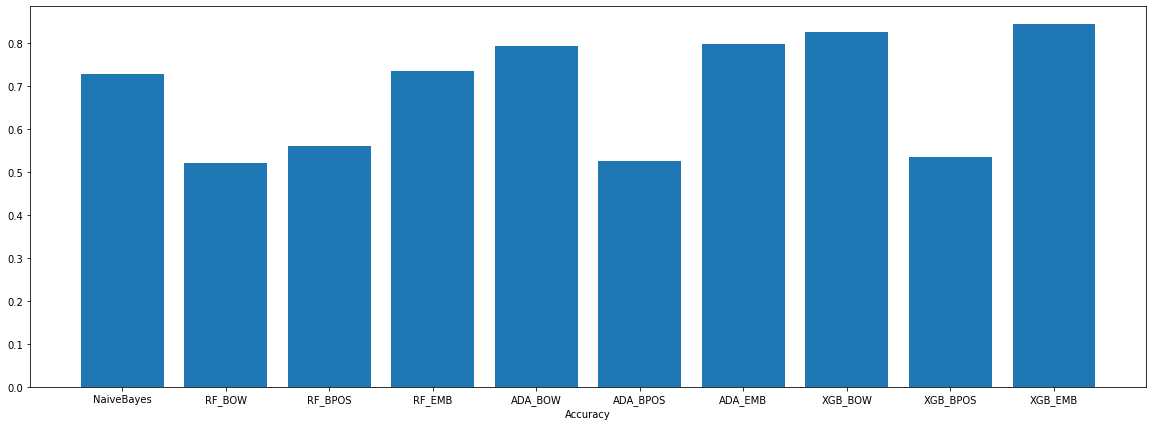

In [90]:
fig, ax = plt.subplots(figsize=(20,7))
plt.xlabel('Accuracy')
keys = accuracy.keys()
values = accuracy.values()

plt.bar(keys, values)
accuracy

{'NaiveBayes': 0.7930632630410654,
 'RF_BOW': 0.8283851276359601,
 'RF_BPOS': 0.6692563817980022,
 'RF_EMB': 0.8475860155382907,
 'ADA_BOW': 0.8513179800221975,
 'ADA_BPOS': 0.5780105438401776,
 'ADA_EMB': 0.8734461709211987,
 'XGB_BOW': 0.9134850166481687,
 'XGB_BPOS': 0.5850166481687015,
 'XGB_EMB': 0.9141231964483907}

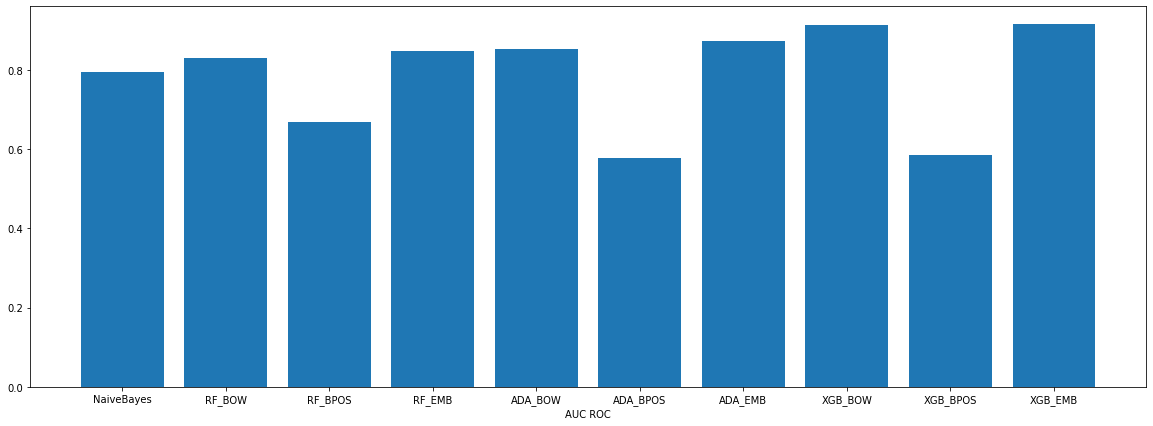

In [91]:
fig, ax = plt.subplots(figsize=(20,7))
plt.xlabel('AUC ROC')
keys = auc_roc.keys()
values = auc_roc.values()

plt.bar(keys, values)
auc_roc

# Deeplearning models

We classify Covid-19 tweets using the following deeplearning models: 

* Simple RNN
* LSTM
* GRU 
* Bidirectional LSTM
* BERT

The tweets are preprocessed using the following NLP methods before being fed as inputs to the neural network models: 

* Keras embedding layers 
* Pre-trained Spacy word embeddings

# NLP preprocessing steps

* Randomly reshuffle data
* Estimate embedding matrix with Keras 
* Initialize Keras embedding layer with pre-trained Spacy word embedding


In [117]:
df = pd.read_csv("./binary_data.csv")
df.shape

(6358, 3)

In [118]:
# reshuffle data
np.random.seed(0)
df = df.reindex(np.random.permutation(df.index))
df = df.reset_index(drop=True) # reset the index after the permutation

In [119]:
# remove punctuation, non alphanumerical characters and lowercase
df["tweet_clean"] = df['OriginalTweet'].apply(preprocessor)

In [120]:
# load pre-trained word embedding model from spacy
nlp = spacy.load('en_core_web_md') 

# stack embeddings of tweets
emb = np.vstack(df.tweet_clean.apply(lambda x: nlp(x).vector))

savetxt('./embedded_data.csv', emb, delimiter=',')

## Basic preprocessing: 

* Convert to lowercase and split tokens on whitespaces and puncutuation
* Map every word to an integer value
* Set each tweet to an equal length  𝑇  by padding with 0 or slicing 

## Hyperparameters for Keras preprocessor

* num_words: size of the vocabulary based on most frequent words in tweets
* maxlen: sequence length $T$ to ensure that all tweets have the same length 

In [97]:
# find size of vocabulary = number of words that appear more than 1 time 
counts = Counter()
for i, news in enumerate(df['OriginalTweet']):
    text = news.lower() # convert to lowercase
    df.loc[i, "OriginalTweet"] = text
    counts.update(text.split()) # splitting on whitespace

In [98]:
print('Number of unique words:', len(counts))
print('Number of words that appear more than 1 time:', len( [k for k, v in counts.items() if v > 1] ))
print('Number of words that appear more than 10 times:', len( [k for k, v in counts.items() if v > 10] ))

Number of unique words: 18506
Number of words that appear more than 1 time: 18506
Number of words that appear more than 10 times: 1899


In [99]:
# our vocabulary consists of words that appear more than 10 times 
vocab_size = len( [k for k, v in counts.items() if v > 10] )

In [100]:
# most frequent words that appear more than 5 times
word_counts = sorted(counts, key=counts.get, reverse=True)
word_counts = word_counts[1:vocab_size]
print( word_counts[:20] ) # show first 20 words

['to', 'and', 'of', 'a', 'in', 'for', '#covid_19', 'is', 'i', 'are', '#coronavirus', 'food', 'you', 'on', 'at', 'this', 'grocery', 'be', 'people', 'store']


In [101]:
# assign an index to all words in word_counts
word_to_int = {}
for i, word in enumerate(word_counts): 
    word_to_int[word] = i

In [102]:
# create a list with all tweets, where each tweet contains only the indexes of most frequent words
mapped_tweet = []
for tweet in df['OriginalTweet']:
    mapped_tweet.append([word_to_int[word] 
                           for word in tweet.split() 
                           if word in word_to_int.keys()])
    
print( mapped_tweet[:10] )

[[486, 341, 0, 26, 355, 487, 2, 1, 2, 26, 655, 88, 18, 72, 2, 2], [918, 90, 14, 16, 19, 8, 96, 14, 7, 1655, 3, 396, 72, 2, 26, 381, 2, 199, 2, 473, 9, 177, 62, 14, 10, 6], [8, 153, 62, 1, 62, 656, 44, 1, 388, 4, 47, 25, 26, 33, 212, 111, 127, 305, 24, 107, 356, 3, 0, 84, 25, 1094, 42, 41, 27, 236, 101, 70, 397, 1095, 10], [52, 65, 1096, 175, 242, 18, 9, 236, 561, 2, 488, 35, 3, 6], [47, 1097, 474, 1474, 89, 1, 41, 23, 42, 0, 849, 64, 7, 77], [224, 3, 850, 3, 52, 133, 10, 132, 105, 6], [15, 14, 1202, 1, 414, 1656, 34, 217, 522, 0, 98, 456, 2, 1, 475, 2, 116, 0, 371, 414, 39, 199, 36, 108, 107, 20, 0, 1002, 44, 200, 851, 37, 55, 1657], [42, 41, 151, 1658, 4, 1316, 195, 523, 1098, 1, 1475, 99, 98, 179, 10, 489, 1203], [34, 17, 0, 852, 0, 13, 1317, 562, 14, 4, 3, 1318, 323, 0], [1204, 1659, 9, 2, 17, 229, 39, 94, 27, 71, 582, 4, 342, 415, 1476, 29, 456, 7, 4, 1660, 131, 262, 48, 218, 161, 355]]


In [103]:
# set length of each tweet equal to median length of mapped_tweet
sequence_length = np.median([len(tweet) for tweet in mapped_tweet])
sequence_length

26.0

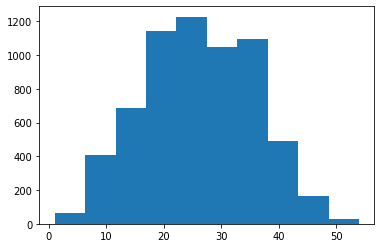

In [104]:
rev_lengths = np.array([len(tweet) for tweet in mapped_tweet])
plt.hist(rev_lengths)
plt.show()

In [105]:
# map words to integers with preprocessing using keras tokenizer
tokenizer = Tokenizer(num_words=vocab_size, 
                      filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', # filters out all punctuation
                      lower=True, # convert to lowercase
                      split=' ') # split on whitespaces

tokenizer.fit_on_texts(df['OriginalTweet'])
list_tokenized = tokenizer.texts_to_sequences(df['OriginalTweet'])

print( list_tokenized[:10] )

[[995, 483, 377, 2, 242, 35, 357, 468, 319, 484, 7, 535, 4, 1, 7, 35, 696, 97, 24, 79, 7, 1, 7, 72, 12, 10, 11], [162, 93, 22, 1, 25, 21, 17, 95, 22, 16, 1673, 8, 384, 79, 7, 35, 1, 315, 7, 5, 6, 7, 1, 378, 31, 18, 197, 263, 67, 22, 828, 3, 14, 5, 6], [17, 167, 67, 4, 67, 697, 55, 1, 190, 4, 385, 9, 57, 698, 32, 35, 1, 1674, 33, 1, 201, 120, 114, 338, 31, 118, 386, 8, 2, 90, 32, 784, 44, 42, 34, 277, 102, 78, 443, 149, 14, 1508], [48, 76, 829, 192, 431, 1675, 236, 24, 18, 277, 582, 7, 1, 1256, 536, 45, 8, 3, 5, 6], [57, 1159, 485, 75, 1160, 96, 4, 42, 1368, 29, 44, 2, 1, 931, 71, 5, 6, 16, 63, 12, 10, 11], [255, 8, 785, 8, 1257, 48, 100, 14, 144, 119, 5, 6, 12, 10, 11], [23, 22, 1068, 4, 398, 1676, 43, 243, 401, 2, 98, 1, 456, 7, 4, 444, 7, 130, 1369, 2, 413, 398, 50, 5, 6, 47, 107, 118, 28, 2, 830, 55, 1161, 15, 1370, 221, 932, 49, 62, 154], [158, 44, 42, 168, 1677, 9, 1, 1162, 786, 194, 500, 831, 4, 1509, 99, 98, 202, 1, 615, 3, 3, 14, 5, 996, 3, 12, 10, 11], [1, 272, 43, 27, 2, 933,

In [106]:
# dictionary of words with indices
word_index = tokenizer.word_index

In [107]:
# convert all tweets to same length by padding with 0 or slicing
sequence_length = 35 # select 35 as max length based on distribution of mapped tweets
sequences = pad_sequences(list_tokenized, maxlen= sequence_length)
print(sequences)

[[   0    0    0 ...   12   10   11]
 [ 162   93   22 ...   14    5    6]
 [   1  190    4 ...  149   14 1508]
 ...
 [   0    0    0 ...   36    5    6]
 [   1   81    3 ...   12   10   11]
 [   0    0    0 ...   12   10   11]]


In [108]:
# convert sentiment to real valued
le = LabelEncoder()
le.fit(df['Sentiment'])
df['target_encoded'] = le.transform(df['Sentiment'])

In [109]:
df_processed = pd.concat([df[['Sentiment', "target_encoded", "tweet_clean"]], pd.DataFrame(sequences)], axis=1)
df_processed.head()

,Sentiment,target_encoded,tweet_clean,0,1,2,3,4,5,6,...,25,26,27,28,29,30,31,32,33,34
0,Negative,0,breaking ontario s chief medical officer dr d...,0,0,0,0,0,0,0,...,97,24,79,7,1,7,72,12,10,11
1,Negative,0,well everyone at the grocery store i work at i...,162,93,22,1,25,21,17,...,18,197,263,67,22,828,3,14,5,6
2,Negative,0,i am more and more concerned about the elderly...,1,190,4,385,9,57,698,...,44,42,34,277,102,78,443,149,14,1508
3,Positive,1,supermarket was unusually busy last night mana...,0,0,0,0,0,0,0,...,582,7,1,1256,536,45,8,3,5,6
4,Negative,0,our latest report how department stores and sh...,0,0,0,0,0,0,0,...,1,931,71,5,6,16,63,12,10,11


In [110]:
# save data
df_processed.to_csv("./data_deeplearning.csv", index = False, encoding = "utf-8")

# Recurrent neural networks (RNN)

* The machine learning approach to text analysis relies heavily on text preprocessing
* RNNs are used to implement most of the NLP preprocessing as well as classification tasks

A RNN is a neural network architecture suited to deal with sequential data. In contrast to feedforward neural networks, they allow for cycles in their architecture in order to take into account the activations of the previous step. Hence, they have some form of "memory" of the structure of the training data. 

For input data $x = (x_1, ..., x_T)$, the RNN architecture computes a sequence of outputs $(z_1^1, ..., z_T^1)$, where each output isa function of the feature information at the same timestep and the output information from the previous timestep, i.e. $z_{j+1}^1 = z^1(x_{j+1}, z_j^1), \forall j = 1, ..., T-1$

The most commonly used gradient-based learning algorithm to
update RNN parameters is Backpropagation Through Time (BPTT), which is applied to
the unfolded network in order to compute the gradients at each timestep. However, the recurisve computation of these gradients often lead to exploding or vanishing gradients. Gated RNN architectures, such as Long Short-Term Memory (LSTM) or Gated Recurrent Units (GRU) solve this problem.

--------------------------------------------------------------------------------------------------

The models are trained on the following NLP preprocessed data: 

* **Word embeddings**: word embeddings are trained using Keras embedding layer, which converts each word into fixed length, dense, real-valued vector of defined size.
    Parameters:

    * input_dim : Size of the vocabulary (equal to the size of the embedding matrix)
    * output_dim : Length of the vector for each word
    * input_length : Maximum length of a sequence

* **Pre-trained Spacy word embeddings**: used as weights in Keras embedding layer (transfer learning). Additional parameters:

    * weights: Embedding matrix computed from pretrained Spacy embeddings
    * trainable = False: do not retrain word embeddings

In [195]:
df = pd.read_csv("./data_deeplearning.csv")

In [196]:
# define train and test size
train_size = int( len(df)*0.8 )
test_size = int( len(df) - train_size )
print(train_size, test_size)

5086 1272


In [197]:
remove = ['Sentiment', "target_encoded", "tweet_clean"]

# split dataset
X_train = np.array(df.head(train_size).drop(remove, axis=1)) # replace with n_train
y_train = df.head(train_size).target_encoded.values

X_test = np.array(df.tail(test_size).drop(remove, axis=1)) # replace with n_test
y_test = df.tail(test_size).target_encoded.values

print('Training data X, y:', X_train.shape, y_train.shape)
print('Testing data X, y:', X_test.shape, y_test.shape)

Training data X, y: (5086, 35) (5086,)
Testing data X, y: (1272, 35) (1272,)


In [ ]:
# load embedding matrix
emb = loadtxt('.\embedded_data.csv', delimiter=',')

In [125]:
emb

array([[-0.09333853,  0.1594261 , -0.1452548 , ..., -0.03331466,
        -0.03441611,  0.0427052 ],
       [-0.16302398,  0.14447643, -0.10208585, ..., -0.07374032,
        -0.02447238,  0.1317673 ],
       [-0.04818401,  0.13328686, -0.15964565, ..., -0.12183905,
        -0.00723264,  0.19176084],
       ...,
       [-0.13488412,  0.14941937, -0.00276903, ..., -0.1538148 ,
         0.06794567,  0.15904558],
       [-0.06944237,  0.16937111, -0.08186831, ..., -0.04054378,
         0.03973036,  0.13870232],
       [-0.06363338,  0.07741906, -0.03048446, ..., -0.11634912,
        -0.01054995,  0.21314113]], dtype=float32)

## Simple RNN

In [126]:
# paramerers, based on results from preprocessing
emb_length = 300
max_length = 58 # length of longest sequence
sequence_length = 35 

### Keras embedding layer

In [127]:
# define model
model = tf.keras.Sequential()
model.add(layers.Embedding(input_dim = len(emb),
                 output_dim = emb_length,
                 input_length = sequence_length))

model.add(layers.SimpleRNN(sequence_length, activation='sigmoid'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

2021-12-09 09:00:11.062607: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-09 09:00:11.063904: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-09 09:00:11.064686: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-09 09:00:11.065575: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [128]:
# define callbacks for early stopping during training
# stop training when the validation loss `val_accuracy` is no longer improving
callbacks = [tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    min_delta=1e-2,
    patience=3,
    verbose=1,
    restore_best_weights=True)]

In [129]:
# train the model
history = model.fit(X_train, 
         y_train, 
         validation_data = (X_test, y_test),
         epochs=7, 
         batch_size=32,
         callbacks=callbacks,
         verbose=1)

model.save("SimpleRNN_1")

2021-12-09 09:00:29.996433: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/7
159/159 [==============================] - 8s 42ms/step - loss: 0.7231 - accuracy: 0.5130 - val_loss: 0.6857 - val_accuracy: 0.5637
Epoch 2/7
159/159 [==============================] - 6s 38ms/step - loss: 0.6855 - accuracy: 0.5448 - val_loss: 0.6651 - val_accuracy: 0.5983
Epoch 3/7
159/159 [==============================] - 7s 44ms/step - loss: 0.6307 - accuracy: 0.6180 - val_loss: 0.6529 - val_accuracy: 0.5794
Epoch 4/7
159/159 [==============================] - 6s 38ms/step - loss: 0.5953 - accuracy: 0.6366 - val_loss: 0.6273 - val_accuracy: 0.6101
Epoch 5/7
159/159 [==============================] - 6s 41ms/step - loss: 0.5403 - accuracy: 0.7027 - val_loss: 0.5789 - val_accuracy: 0.6887
Epoch 6/7
159/159 [==============================] - 6s 37ms/step - loss: 0.4491 - accuracy: 0.7993 - val_loss: 0.5048 - val_accuracy: 0.7697
Epoch 7/7
159/159 [==============================] - 6s 40ms/step - loss: 0.3574 - accuracy: 0.8634 - val_loss: 0.4840 - val_accuracy: 0.7956


2021-12-09 09:01:17.477949: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


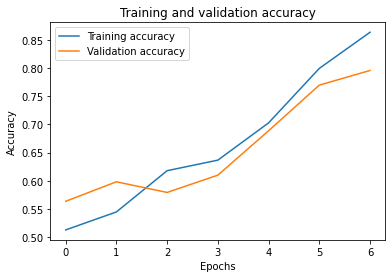

In [130]:
# plot the development of the accuracy over epochs to see the training progress
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

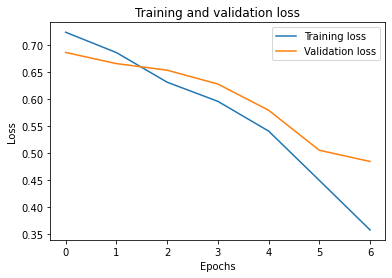

In [131]:
# plot the development of the loss over epochs to see the training progress
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

### Pre-trained Spacy embedding

In [132]:
# define model
model = tf.keras.Sequential()
model.add(layers.Embedding(input_dim = len(emb),
                 output_dim = emb_length,
                 weights=[emb],
                 input_length = sequence_length, 
                 trainable = False))

model.add(layers.SimpleRNN(sequence_length, activation='sigmoid'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

In [133]:
# define callbacks for early stopping during training
# stop training when the validation loss `val_accuracy` is no longer improving
callbacks = [tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    min_delta=1e-3,
    patience=5,
    verbose=1,
    restore_best_weights=True)]

In [134]:
# train the model
history = model.fit(X_train, 
         y_train, 
         validation_data = (X_test, y_test),
         epochs=20, 
         batch_size=32,
         callbacks=callbacks,
         verbose=1)

model.save("SimpleRNN_2")

Epoch 1/20
159/159 [==============================] - 6s 35ms/step - loss: 0.7234 - accuracy: 0.5149 - val_loss: 0.6913 - val_accuracy: 0.5314
Epoch 2/20
159/159 [==============================] - 5s 33ms/step - loss: 0.7061 - accuracy: 0.4947 - val_loss: 0.6913 - val_accuracy: 0.5142
Epoch 3/20
159/159 [==============================] - 6s 40ms/step - loss: 0.7010 - accuracy: 0.5000 - val_loss: 0.6925 - val_accuracy: 0.5055
Epoch 4/20
159/159 [==============================] - 5s 32ms/step - loss: 0.6948 - accuracy: 0.5220 - val_loss: 0.6920 - val_accuracy: 0.4984
Epoch 5/20
159/159 [==============================] - 5s 34ms/step - loss: 0.6955 - accuracy: 0.5090 - val_loss: 0.6911 - val_accuracy: 0.5425
Epoch 6/20
159/159 [==============================] - 5s 32ms/step - loss: 0.6937 - accuracy: 0.5061 - val_loss: 0.6913 - val_accuracy: 0.5157
Epoch 7/20
159/159 [==============================] - 5s 32ms/step - loss: 0.6918 - accuracy: 0.5258 - val_loss: 0.6910 - val_accuracy: 0.5157

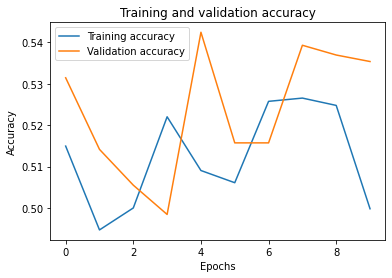

In [135]:
# plot the development of the accuracy over epochs to see the training progress
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

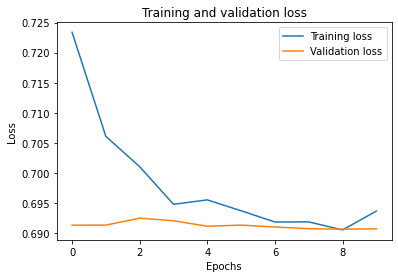

In [136]:
# plot the development of the loss over epochs to see the training progress
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

## LSTM

LSTM units replace hidden neurons in RNN architectures by more complex
    memory cells. A memory cell takes three inputs: the input features $x_t$, the neural activations $z_{t-1}^1$ and the cell state $c_{t-1}^1$ from the previous step, and outputs a new cell state $c_t^1$ and neural activations $z_t^1$. Each memory cell consists of three gates that control the flow of information through the cell: 
    
* **Forget Gate**: this gate decides what information should be thrown away or kept. Information from the previous hidden state and information from the current input is passed through the sigmoid function. Values come out between 0 and 1. The closer to 0 means to forget, and the closer to 1 means to keep.
* **Input Gate**: to update the cell state, we have the input gate. First, we pass the previous hidden state and current input into a sigmoid function. That decides which values will be updated by transforming the values to be between 0 and 1. 0 means not important, and 1 means important. 
* **Output gate**: the output gate decides what the next hidden state, which contains information on previous inputs, should be. The hidden state is also used for predictions. First, we pass the previous hidden state and the current input into a sigmoid function. Then we pass the newly modified cell state to the tanh function. We multiply the tanh output with the sigmoid output to decide what information the hidden state should carry. The output is the hidden state. The new cell state and the new hidden is then carried over to the next time step.

### Keras embedding layer

In [137]:
# define model
model = tf.keras.Sequential()
model.add(layers.Embedding(input_dim = len(emb),
                 output_dim = emb_length,
                 input_length = sequence_length))

model.add(layers.LSTM(sequence_length, dropout=0.3, recurrent_dropout=0.3))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

In [138]:
# define callbacks for early stopping during training
# stop training when the validation loss `val_accuracy` is no longer improving
callbacks = [tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    min_delta=1e-2,
    patience=3,
    verbose=1,
    restore_best_weights=True)]

In [139]:
# train the model
history = model.fit(X_train, 
                    y_train, 
                    validation_data = (X_test, y_test),
                    epochs=7, 
                    batch_size=32,
                    callbacks=callbacks,
                    verbose=1)

model.save("LSTM_1")

Epoch 1/7
159/159 [==============================] - 30s 173ms/step - loss: 0.6096 - accuracy: 0.6483 - val_loss: 0.4930 - val_accuracy: 0.7712
Epoch 2/7
159/159 [==============================] - 28s 178ms/step - loss: 0.3504 - accuracy: 0.8602 - val_loss: 0.4594 - val_accuracy: 0.8184
Epoch 3/7
159/159 [==============================] - 28s 178ms/step - loss: 0.2365 - accuracy: 0.9157 - val_loss: 0.3808 - val_accuracy: 0.8601
Epoch 4/7
159/159 [==============================] - 28s 179ms/step - loss: 0.1661 - accuracy: 0.9434 - val_loss: 0.3495 - val_accuracy: 0.8797
Epoch 5/7
159/159 [==============================] - 28s 178ms/step - loss: 0.1193 - accuracy: 0.9624 - val_loss: 0.3843 - val_accuracy: 0.8899
Epoch 6/7
159/159 [==============================] - 28s 176ms/step - loss: 0.0953 - accuracy: 0.9721 - val_loss: 0.3495 - val_accuracy: 0.9057
Epoch 7/7
159/159 [==============================] - 28s 178ms/step - loss: 0.0682 - accuracy: 0.9805 - val_loss: 0.4530 - val_accuracy:

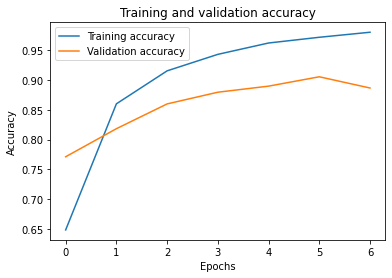

In [140]:
# plot the development of the accuracy over epochs to see the training progress
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

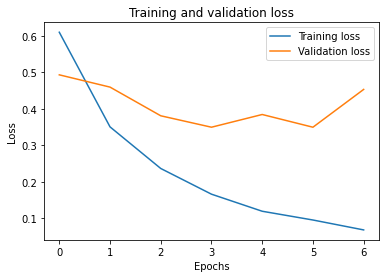

In [141]:
# plot the development of the loss over epochs to see the training progress
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

### Pre-trained word embeddings

In [142]:
# define model
model = tf.keras.Sequential()
model.add(layers.Embedding(input_dim = len(emb),
                 output_dim = emb_length,
                 weights=[emb],
                 input_length = sequence_length, 
                 trainable = False))

model.add(layers.LSTM(sequence_length, dropout=0.3, recurrent_dropout=0.3))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

In [143]:
# define callbacks for early stopping during training
# stop training when the validation loss `val_accuracy` is no longer improving
callbacks = [tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    min_delta=1e-3,
    patience=5,
    verbose=1,
    restore_best_weights=True)]

In [144]:
# train the model
history = model.fit(X_train, 
                    y_train, 
                    validation_data = (X_test, y_test),
                    epochs=30, 
                    batch_size=32,
                    callbacks=callbacks,
                    verbose=1)

model.save("LSTM_2")

Epoch 1/30
159/159 [==============================] - 27s 157ms/step - loss: 0.6989 - accuracy: 0.5059 - val_loss: 0.6911 - val_accuracy: 0.5157
Epoch 2/30
159/159 [==============================] - 25s 158ms/step - loss: 0.6939 - accuracy: 0.5206 - val_loss: 0.6907 - val_accuracy: 0.5409
Epoch 3/30
159/159 [==============================] - 24s 154ms/step - loss: 0.6929 - accuracy: 0.5165 - val_loss: 0.6918 - val_accuracy: 0.5134
Epoch 4/30
159/159 [==============================] - 25s 158ms/step - loss: 0.6919 - accuracy: 0.5340 - val_loss: 0.6902 - val_accuracy: 0.5440
Epoch 5/30
159/159 [==============================] - 25s 155ms/step - loss: 0.6903 - accuracy: 0.5324 - val_loss: 0.6897 - val_accuracy: 0.5354
Epoch 6/30
159/159 [==============================] - 25s 154ms/step - loss: 0.6902 - accuracy: 0.5328 - val_loss: 0.6891 - val_accuracy: 0.5204
Epoch 7/30
159/159 [==============================] - 24s 153ms/step - loss: 0.6907 - accuracy: 0.5248 - val_loss: 0.6889 - val_ac

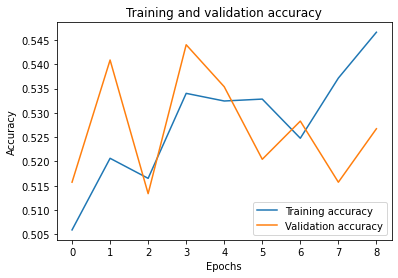

In [145]:
# plot the development of the accuracy over epochs to see the training progress
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

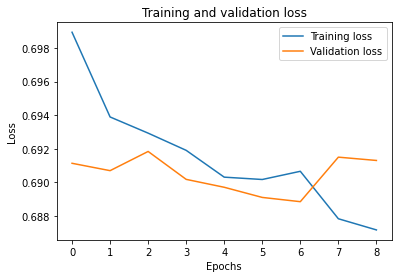

In [146]:
# plot the development of the loss over epochs to see the training progress
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

GRU
-------------------------------------------------------------------------------

Uses a similar but less complex memory cell architecture as LSTM, composed by:

* **Update gate**: It determines how much of the past knowledge needs to be passed along into the future. It is analogous to the output gate in an LSTM recurrent unit.

* **Reset gate**:  It determines how much of the past knowledge to forget. It is analogous to the combination of the input Gate and the forget Gate in an LSTM recurrent unit.

* **Current Memory Gate**: It is incorporated into the Reset Gate and is used to introduce some non-linearity into the input and to also make the input zero-mean. It also reduces the effect that previous information has on the current information that is being passed into the future.

### Keras embedding layer

In [147]:
# define model
model = tf.keras.Sequential()
model.add(layers.Embedding(input_dim = len(emb),
                 output_dim = emb_length,
                 input_length = sequence_length))


model.add(layers.SpatialDropout1D(0.3))
model.add(layers.GRU(sequence_length))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

In [148]:
# define callbacks for early stopping during training
# stop training when the validation loss `val_accuracy` is no longer improving
callbacks = [tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    min_delta=1e-3,
    patience=5,
    verbose=1,
    restore_best_weights=True)]

In [149]:
# train the model
history = model.fit(X_train, 
                    y_train, 
                    validation_data = (X_test, y_test),
                    epochs=10, 
                    batch_size=32,
                    callbacks=callbacks,
                    verbose=1)

model.save("GRU_1")

Epoch 1/10


2021-12-09 09:11:00.466945: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


159/159 [==============================] - 4s 8ms/step - loss: 0.6442 - accuracy: 0.6074 - val_loss: 0.4746 - val_accuracy: 0.7704
Epoch 2/10
159/159 [==============================] - 1s 6ms/step - loss: 0.3669 - accuracy: 0.8462 - val_loss: 0.3984 - val_accuracy: 0.8270
Epoch 3/10
159/159 [==============================] - 1s 6ms/step - loss: 0.2298 - accuracy: 0.9147 - val_loss: 0.3743 - val_accuracy: 0.8506
Epoch 4/10
159/159 [==============================] - 1s 9ms/step - loss: 0.1578 - accuracy: 0.9451 - val_loss: 0.3259 - val_accuracy: 0.8868
Epoch 5/10
159/159 [==============================] - 1s 8ms/step - loss: 0.1014 - accuracy: 0.9691 - val_loss: 0.3555 - val_accuracy: 0.8923
Epoch 6/10
159/159 [==============================] - 1s 6ms/step - loss: 0.0670 - accuracy: 0.9823 - val_loss: 0.3202 - val_accuracy: 0.9135
Epoch 7/10
159/159 [==============================] - 1s 6ms/step - loss: 0.0474 - accuracy: 0.9876 - val_loss: 0.3435 - val_accuracy: 0.9104
Epoch 8/10
159/15

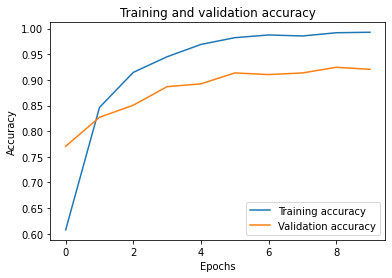

In [150]:
# plot the development of the accuracy over epochs to see the training progress
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

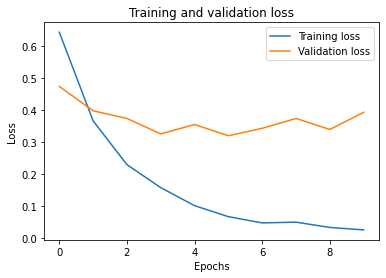

In [151]:
# plot the development of the loss over epochs to see the training progress
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

### Pre-trained word embeddings

In [152]:
# define model
model = tf.keras.Sequential()
model.add(layers.Embedding(input_dim = len(emb),
                 output_dim = emb_length,
                 weights=[emb],
                 input_length = sequence_length, 
                 trainable = False))


model.add(layers.SpatialDropout1D(0.3))
model.add(layers.GRU(sequence_length))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

In [153]:
# define callbacks for early stopping during training
# stop training when the validation loss `val_accuracy` is no longer improving
callbacks = [tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    min_delta=1e-3,
    patience=5,
    verbose=1,
    restore_best_weights=True)]

In [154]:
# train the model
history = model.fit(X_train, 
                    y_train, 
                    validation_data = (X_test, y_test),
                    epochs=30, 
                    batch_size=32,
                    callbacks=callbacks,
                    verbose=1)

model.save("GRU_2")

Epoch 1/30
159/159 [==============================] - 3s 9ms/step - loss: 0.7028 - accuracy: 0.5112 - val_loss: 0.6926 - val_accuracy: 0.5142
Epoch 2/30
159/159 [==============================] - 1s 6ms/step - loss: 0.6967 - accuracy: 0.5104 - val_loss: 0.6904 - val_accuracy: 0.5314
Epoch 3/30
159/159 [==============================] - 1s 6ms/step - loss: 0.6981 - accuracy: 0.5153 - val_loss: 0.6899 - val_accuracy: 0.5291
Epoch 4/30
159/159 [==============================] - 1s 5ms/step - loss: 0.6925 - accuracy: 0.5240 - val_loss: 0.6887 - val_accuracy: 0.5299
Epoch 5/30
159/159 [==============================] - 1s 5ms/step - loss: 0.6940 - accuracy: 0.5203 - val_loss: 0.6887 - val_accuracy: 0.5291
Epoch 6/30
159/159 [==============================] - 1s 5ms/step - loss: 0.6916 - accuracy: 0.5273 - val_loss: 0.6874 - val_accuracy: 0.5456
Epoch 7/30
159/159 [==============================] - 1s 5ms/step - loss: 0.6883 - accuracy: 0.5344 - val_loss: 0.6867 - val_accuracy: 0.5362
Epoch 

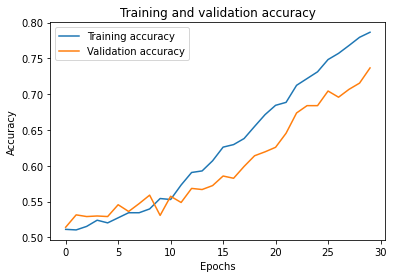

In [155]:
# plot the development of the accuracy over epochs to see the training progress
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

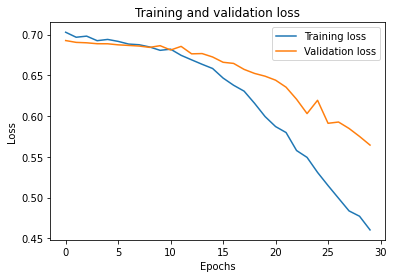

In [156]:
# plot the development of the loss over epochs to see the training progress
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

## Bidirectional RNN

Bidirectional RNN consists of putting two independent RNNs together: one whose input sequence is processed in normal time order, and another which is processed in reverse time order. This way, the network has both backward and forward information about the sequence at every time step.  The outputs of the two RNNs are concatenated at each time step. 

### Keras embedding layer

In [157]:
# define model
model = tf.keras.Sequential()
model.add(layers.Embedding(input_dim = len(emb),
                 output_dim = emb_length,
                 input_length = sequence_length))

model.add(layers.Bidirectional(layers.LSTM(sequence_length, dropout = 0.3, recurrent_dropout = 0.3)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

In [158]:
# define callbacks for early stopping during training
# stop training when the validation loss `val_accuracy` is no longer improving
callbacks = [tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    min_delta=1e-3,
    patience=5,
    verbose=1,
    restore_best_weights=True)]

In [159]:
# train the model
history = model.fit(X_train, 
                    y_train, 
                    validation_data = (X_test, y_test),
                    epochs=10, 
                    batch_size=32,
                    callbacks=callbacks,
                    verbose=1)

model.save("BI_LSTM_1")

Epoch 1/10
159/159 [==============================] - 59s 347ms/step - loss: 0.6003 - accuracy: 0.6610 - val_loss: 0.4956 - val_accuracy: 0.7579
Epoch 2/10
159/159 [==============================] - 55s 344ms/step - loss: 0.3342 - accuracy: 0.8679 - val_loss: 0.3765 - val_accuracy: 0.8310
Epoch 3/10
159/159 [==============================] - 55s 343ms/step - loss: 0.2133 - accuracy: 0.9245 - val_loss: 0.3441 - val_accuracy: 0.8648
Epoch 4/10
159/159 [==============================] - 54s 342ms/step - loss: 0.1474 - accuracy: 0.9499 - val_loss: 0.2793 - val_accuracy: 0.8907
Epoch 5/10
159/159 [==============================] - 54s 343ms/step - loss: 0.0958 - accuracy: 0.9707 - val_loss: 0.3038 - val_accuracy: 0.9088
Epoch 6/10
159/159 [==============================] - 55s 346ms/step - loss: 0.0638 - accuracy: 0.9813 - val_loss: 0.2981 - val_accuracy: 0.9049
Epoch 7/10
159/159 [==============================] - 55s 347ms/step - loss: 0.0610 - accuracy: 0.9801 - val_loss: 0.2879 - val_ac

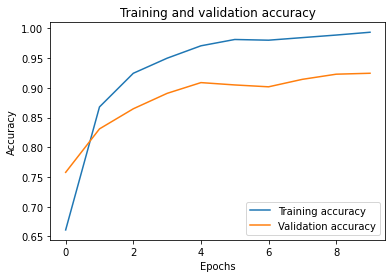

In [160]:
# plot the development of the accuracy over epochs to see the training progress
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

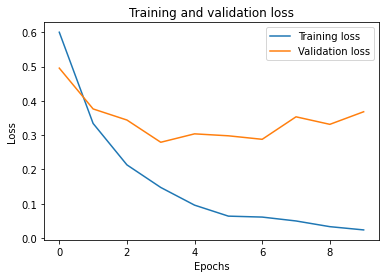

In [161]:
# plot the development of the loss over epochs to see the training progress
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

### Pre-trained word embeddings

In [162]:
# define model
model = tf.keras.Sequential()
model.add(layers.Embedding(input_dim = len(emb),
                 output_dim = emb_length,
                 weights=[emb],
                 input_length = sequence_length, 
                 trainable = False))

model.add(layers.Bidirectional(layers.LSTM(sequence_length, dropout = 0.3, recurrent_dropout = 0.3)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

In [163]:
# define callbacks for early stopping during training
# stop training when the validation loss `val_accuracy` is no longer improving
callbacks = [tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    min_delta=1e-3,
    patience=5,
    verbose=1,
    restore_best_weights=True)]

In [164]:
# train the model
history = model.fit(X_train, 
                    y_train, 
                    validation_data = (X_test, y_test),
                    epochs=30, 
                    batch_size=32,
                    callbacks=callbacks,
                    verbose=1)

model.save("BI_LSTM_2")

Epoch 1/30
159/159 [==============================] - 54s 315ms/step - loss: 0.7012 - accuracy: 0.5049 - val_loss: 0.6928 - val_accuracy: 0.5157
Epoch 2/30
159/159 [==============================] - 49s 307ms/step - loss: 0.6953 - accuracy: 0.5090 - val_loss: 0.6895 - val_accuracy: 0.5409
Epoch 3/30
159/159 [==============================] - 50s 316ms/step - loss: 0.6916 - accuracy: 0.5252 - val_loss: 0.6899 - val_accuracy: 0.5307
Epoch 4/30
159/159 [==============================] - 49s 307ms/step - loss: 0.6904 - accuracy: 0.5358 - val_loss: 0.6907 - val_accuracy: 0.5291
Epoch 5/30
159/159 [==============================] - 50s 315ms/step - loss: 0.6888 - accuracy: 0.5354 - val_loss: 0.6869 - val_accuracy: 0.5432
Epoch 6/30
159/159 [==============================] - 49s 307ms/step - loss: 0.6878 - accuracy: 0.5409 - val_loss: 0.6862 - val_accuracy: 0.5369
Epoch 7/30
159/159 [==============================] - 48s 303ms/step - loss: 0.6863 - accuracy: 0.5376 - val_loss: 0.6870 - val_ac

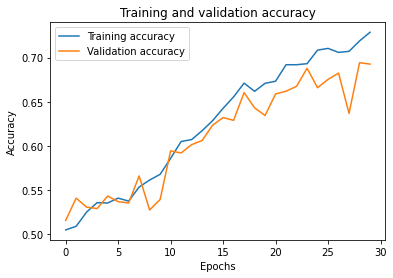

In [165]:
# plot the development of the accuracy over epochs to see the training progress
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

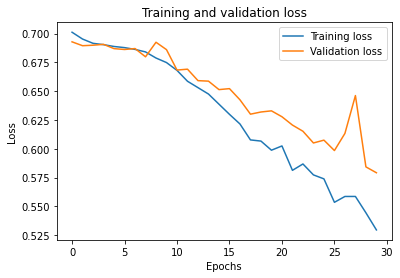

In [166]:
# plot the development of the loss over epochs to see the training progress
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [205]:
model_names = ["SimpleRNN_1", "SimpleRNN_2", "LSTM_1", "LSTM_2", "GRU_1", "GRU_2"]

acc = dict()
auc_res = dict()
for model in model_names: 
    loaded_model = tf.keras.models.load_model(model)
    results = loaded_model.evaluate(X_test, y_test, batch_size=32, verbose=0)
    acc[model] = results[1]

{'SimpleRNN_1': 0.795597493648529,
 'SimpleRNN_2': 0.5424528121948242,
 'LSTM_1': 0.8867924809455872,
 'LSTM_2': 0.544025182723999,
 'GRU_1': 0.920597493648529,
 'GRU_2': 0.7366352081298828}

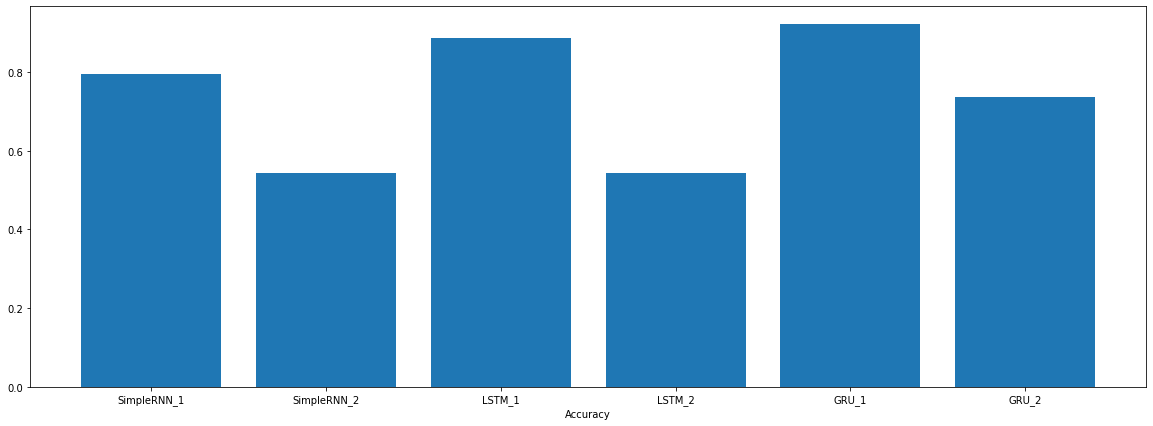

In [206]:
fig, ax = plt.subplots(figsize=(20,7))
plt.xlabel('Accuracy')
keys = acc.keys()
values = acc.values()
plt.bar(keys, values)
acc

# BERT 

BERT (Bidirectional Encoder Representations from Transformers) is a pre-trained machine learning model for NLP tasks:

* Base model: 12-layers, 768-hidden, 12-heads, 110M parameter neural network
* Large model: 24-layer, 1024-hidden, 16-heads, 340M parameter neural network

A transformer is a deep learning model that adopts the mechanism of attention, differentially weighting the significance of each part of the input data. Like recurrent neural networks (RNNs), transformers are designed to handle sequential input data, such as natural language, although they do not necessarily process the data in order. Rather, the attention mechanism helps the transformer encoder identify the contextual relations between words in a text. This feature allows for more parallelization than RNNs and therefore reduces training times.

The transformer encoder takes as input a sequence of tokens, which are embedded into real-valued vectors and processed in the neural network. 

Training strategies: 

* Masked LM (MLM): before processing word sequences, 15% of the words in each sequence are masked, so that the model attempts to predict the masked tokens based on the context. 
* Next sentence prediction (NSP): the model receives pairs of sentences as input and learns to predict if the second sentence in the pair is the subsequent sentence in the original document.

When training the BERT model, Masked LM and Next Sentence Prediction are trained together, with the goal of minimizing the combined loss function of the two strategies.

-------------------------------------------------------------------------------------------

Before being used by BERT as inputs, the tweets are preprocessed using the transformers encoder: 

* input ids: token indices, i.e. numerical representations of token sequences that will be used as input by the model
* attention mask: optional argument, indicates which tokens should be attended to and which should not. Sequences of different lengths are padded/sliced until they are of the same dimension; the attention mask indicates the position of the padded indices, so that the model knows which token ids to ignore.

We add a dense, a dropout and an output layer to the pre-trained BERT model and train only those layers for 3 epochs

In [170]:
df = pd.read_csv("./data_deeplearning.csv")

In [171]:
# define train and test size
train_size = int( len(df)*0.8 )
test_size = int( len(df) - train_size )
print(train_size, test_size)

5086 1272


In [172]:
# split dataset
X_train = df.head(train_size).tweet_clean 
y_train = df.head(train_size).target_encoded

X_test = df.tail(test_size).tweet_clean
y_test = df.tail(test_size).target_encoded

print('Training data X, y:', X_train.shape, y_train.shape)
print('Testing data X, y:', X_test.shape, y_test.shape)

Training data X, y: (5086,) (5086,)
Testing data X, y: (1272,) (1272,)


In [173]:
# paramerers, based on results from preprocessing
emb_length = 300
max_length = 58 # length of longest sequence
sequence_length = 35  

In [174]:
# load pre-trained bert tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased')
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/571 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [175]:
def inputs_bert(data, sequence_length):
    """ preprocess text for BERT model input """
    input_ids = []
    attention_masks = []

    for text in data:
        encoded = tokenizer.encode_plus(
        text, 
        add_special_tokens=True,
        max_length=sequence_length, #set max length of tokens equal to median tweet length
        pad_to_max_length=True,
        return_attention_mask=True)

        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
        
    return np.array(input_ids), np.array(attention_masks)

In [176]:
train_input_ids, train_attention_masks = inputs_bert(X_train, sequence_length)
test_input_ids, test_attention_masks = inputs_bert(X_test, sequence_length)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [177]:
print(train_input_ids.shape, test_input_ids.shape)

(5086, 35) (1272, 35)


In [178]:
# add dense, dropout and output layer to pre-trained model and train only those
input_ids = tf.keras.Input(shape=(sequence_length,),dtype='int32')
attention_masks = tf.keras.Input(shape=(sequence_length,),dtype='int32')

output = bert_model([input_ids, attention_masks])
output = output[1]
output = tf.keras.layers.Dense(sequence_length, activation='relu')(output)
output = tf.keras.layers.Dropout(0.5)(output)
output = tf.keras.layers.Dense(1, activation='sigmoid')(output)

model = tf.keras.models.Model(inputs = [input_ids, attention_masks], outputs = output)
model.compile(optimizer=Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

In [183]:
history = model.fit(
    [train_input_ids, train_attention_masks],
    y_train,
    validation_data = ([test_input_ids, test_attention_masks], y_test), 
    epochs=5,
    batch_size=32)

Epoch 1/5
159/159 [==============================] - 27s 172ms/step - loss: 0.2122 - accuracy: 0.9345 - val_loss: 0.2409 - val_accuracy: 0.9182
Epoch 2/5
159/159 [==============================] - 27s 173ms/step - loss: 0.1287 - accuracy: 0.9650 - val_loss: 0.2404 - val_accuracy: 0.9237
Epoch 3/5
159/159 [==============================] - 28s 173ms/step - loss: 0.0853 - accuracy: 0.9794 - val_loss: 0.1965 - val_accuracy: 0.9426
Epoch 4/5
159/159 [==============================] - 27s 172ms/step - loss: 0.0584 - accuracy: 0.9868 - val_loss: 0.1974 - val_accuracy: 0.9544
Epoch 5/5
159/159 [==============================] - 27s 173ms/step - loss: 0.0422 - accuracy: 0.9910 - val_loss: 0.2455 - val_accuracy: 0.9505


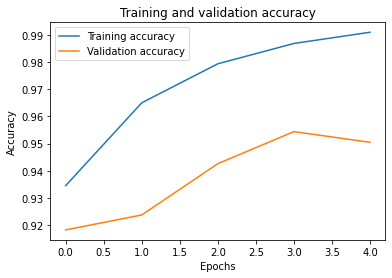

In [184]:
# plot the development of the accuracy over epochs to see the training progress
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

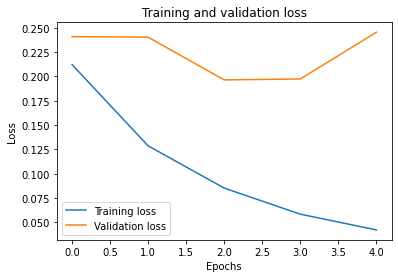

In [185]:
# plot the development of the loss over epochs to see the training progress
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()